In [1]:
!wget https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip

!unzip bike+sharing+dataset.zip

--2024-08-27 12:28:24--  https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bike+sharing+dataset.zip’

bike+sharing+datase     [ <=>                ] 273.43K  --.-KB/s    in 0.08s   

2024-08-27 12:28:24 (3.17 MB/s) - ‘bike+sharing+dataset.zip’ saved [279992]

Archive:  bike+sharing+dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


In [2]:
!pip install category-encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders import TargetEncoder

In [4]:
df = pd.read_csv('hour.csv')
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [5]:
# Create 'day_night' feature based on 'hr'
df['day_night'] = df['hr'].apply(lambda x: 'day' if 6 <= x <= 18 else 'night')

# Drop irrelevant columns
df.drop(['instant', 'casual', 'registered', 'dteday'], axis=1, inplace=True)

# Convert columns to categorical data type
categorical_columns = ['season', 'holiday', 'weekday', 'weathersit', 'workingday', 'mnth', 'yr', 'hr']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# Separating features and target variable
X = df.drop(columns=['cnt']) # Features
y = df['cnt'] # Target

In [6]:
# Numerical features
numerical_features = ['temp', 'hum', 'windspeed']
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', MinMaxScaler())  # Normalize using MinMaxScaler
])

1. Create at least two new interaction features between numerical variables (e.g.,
temp * hum). Justify your choice of features and explain how they might
improve the model's predictive performance.

In [7]:
# Creating interaction features
df['temp_hum_interaction'] = df['temp'] * df['hum']
df['temp_wind_interaction'] = df['temp'] * df['windspeed']
numerical_features.extend(['temp_hum_interaction', 'temp_wind_interaction'])

In [34]:
# Transforming numerical features
X[numerical_features] = numerical_pipeline.fit_transform(df[numerical_features])

# Categorical features
categorical_features = ['season', 'weathersit', 'day_night']

2. Replace the OneHotEncoder with TargetEncoder for categorical variables.
Evaluate how this change impacts the model's performance compared to one-hot
encoding.

In [9]:
# OneHotEncoder pipeline
onehot_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot_encoder', OneHotEncoder(sparse_output=False, drop='first'))
])

# Fit-transform the categorical features with OneHotEncoder
X_encoded_onehot = onehot_pipeline.fit_transform(X[categorical_features])

# Convert it to a DataFrame
X_encoded_onehot = pd.DataFrame(X_encoded_onehot, columns=onehot_pipeline.named_steps['onehot_encoder'].get_feature_names_out(categorical_features))

# Combine encoded categorical features with numerical features
X_onehot = pd.concat([X.drop(columns=categorical_features), X_encoded_onehot], axis=1)

# Train-test split
X_train_onehot, X_test_onehot, y_train, y_test = train_test_split(X_onehot, y, test_size=0.2, random_state=42)

In [10]:
# RandomForestRegressor model using OneHotEncoder
rf_model_onehot = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_onehot.fit(X_train_onehot, y_train)

# Predictions and evaluation for OneHotEncoder
y_pred_rf_onehot = rf_model_onehot.predict(X_test_onehot)
mse_rf_onehot = mean_squared_error(y_test, y_pred_rf_onehot)
r2_rf_onehot = r2_score(y_test, y_pred_rf_onehot)
print(f'RandomForest with OneHotEncoder - MSE: {mse_rf_onehot}, R-squared: {r2_rf_onehot}')

RandomForest with OneHotEncoder - MSE: 1838.4576827722497, R-squared: 0.9419411400269538


In [11]:
# ML Pipeline
final_pipeline_onehot = Pipeline([
('num_preprocess', numerical_pipeline),
('cat_preprocess', onehot_pipeline),
('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

from sklearn import set_config
set_config(display='diagram')# To display
final_pipeline_onehot

Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('onehot_encoder',
                                  OneHotEncoder(drop='first',
                                                sparse_output=False))])),
                ('model', RandomForestRegressor(random_state=42))])

3. Train LinearRegressor:

    a. Using the package,

    b. Write/Train it by scratch following the steps of a linear regressor.

In [18]:
# TargetEncoder pipeline
target_encoder_pipeline = Pipeline([
('imputer', SimpleImputer(strategy='most_frequent')),
('target', TargetEncoder())
])

# Fit-transform the categorical features with TargetEncoder
X_encoded_target = target_encoder_pipeline.fit_transform(X[categorical_features], y)

# Convert it to a DataFrame
X_encoded_target = pd.DataFrame(X_encoded_target,
columns=target_encoder_pipeline.named_steps['target'].get_feature_names_out(categorical_features))

# Combine encoded categorical features with numerical features
X_target = pd.concat([X.drop(columns=categorical_features), X_encoded_target], axis=1)

# Train-test split
X_train_target, X_test_target, y_train, y_test = train_test_split(X_target, y, test_size=0.2, random_state=42)



In [22]:
# RandomForestRegressor model using TargetEncoder
rf_model_target = RandomForestRegressor(n_estimators=100, random_state=42)

# Convert all column names to strings
X_train_target.columns = X_train_target.columns.astype(str)
X_test_target.columns = X_test_target.columns.astype(str)

rf_model_target.fit(X_train_target, y_train)

# Predictions and evaluation for TargetEncoder
y_pred_rf_target = rf_model_target.predict(X_test_target)
mse_rf_target = mean_squared_error(y_test, y_pred_rf_target)
r2_rf_target = r2_score(y_test, y_pred_rf_target)
print(f'RandomForest with TargetEncoder - MSE: {mse_rf_target}, R-squared: {r2_rf_target}')

# Compare the performances
print("Comparison of RandomForest with OneHotEncoder and TargetEncoder:")
print(f"OneHotEncoder - MSE: {mse_rf_onehot}, R-squared: {r2_rf_onehot}")
print(f"TargetEncoder - MSE: {mse_rf_target}, R-squared: {r2_rf_target}")

RandomForest with TargetEncoder - MSE: 1778.720113745503, R-squared: 0.943827664360777
Comparison of RandomForest with OneHotEncoder and TargetEncoder:
OneHotEncoder - MSE: 1838.4576827722497, R-squared: 0.9419411400269538
TargetEncoder - MSE: 1778.720113745503, R-squared: 0.943827664360777


In [23]:
# ML Pipeline
final_pipeline_target = Pipeline([
('num_preprocess', numerical_pipeline),
('cat_preprocess', target_encoder_pipeline),
('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

from sklearn import set_config
set_config(display='diagram')# To display
final_pipeline_target

Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('target', TargetEncoder(cols=[0, 1, 2]))])),
                ('model', RandomForestRegressor(random_state=42))])

3. Train LinearRegressor:

  a. Using the package,

  b. Write/Train it by scratch following the steps of a linear regressor.
  Compare their performance using metrics like Mean Squared Error (MSE)
  and R-squared.

  Compare their performance using metrics like Mean Squared Error (MSE)
  and R-squared.

In [42]:
numerical_features = ['temp', 'hum', 'windspeed']
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', MinMaxScaler())  # Normalize using MinMaxScaler
])

# Creating interaction features
df['temp_hum_interaction'] = df['temp'] * df['hum']
df['temp_wind_interaction'] = df['temp'] * df['windspeed']
numerical_features.extend(['temp_hum_interaction', 'temp_wind_interaction'])

# Transforming numerical features
X_num_transformed = numerical_pipeline.fit_transform(df[numerical_features]) # Transforming the numerical features of df
X_num_transformed = pd.DataFrame(X_num_transformed, columns = numerical_features) # Convert to DataFrame and assign column names

# Concatenate the transformed numerical features with the original DataFrame
X = pd.concat([df, X_num_transformed], axis=1)

# Categorical features

categorical_features = ['season', 'weathersit', 'day_night']
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', TargetEncoder())
])

# Fit-transform the categorical features with TargetEncoder
X_encoded = categorical_pipeline.fit_transform(X[categorical_features], y)

# Converting it to a DataFrame
X_encoded = pd.DataFrame(X_encoded,
columns=categorical_pipeline.named_steps['target_encoder'].get_feature_names_out(categorical_features))


# Combine encoded categorical features with numerical features
X = pd.concat([X.drop(columns=categorical_features), X_encoded], axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


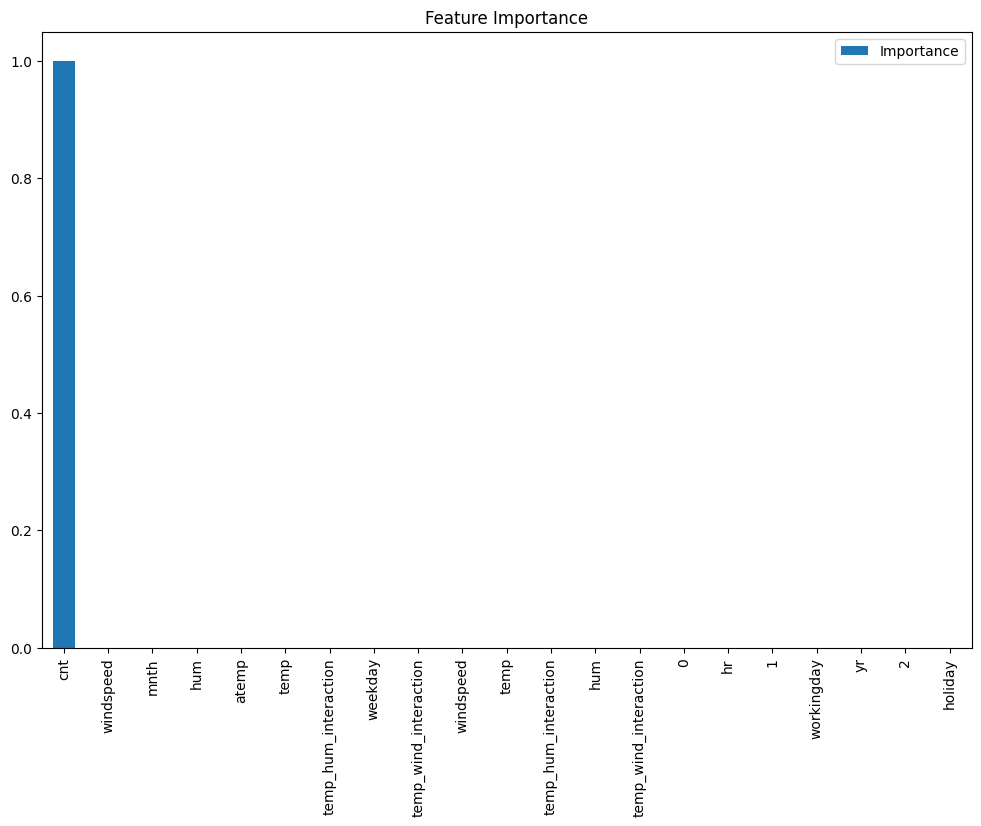

In [43]:
# RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Convert all column names to strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

rf_model.fit(X_train, y_train)

# Feature importance
feat_importances = pd.DataFrame(rf_model.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(12,8))
plt.title('Feature Importance')
plt.show()

In [44]:
# Predictions with RandomForestRegressor
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'RandomForest - MSE: {mse_rf}, R-squared: {r2_rf}')

RandomForest - MSE: 0.0721281645569616, R-squared: 0.9999977221781903


In [62]:


# ML Pipeline
rf_pipeline = Pipeline([
('num_preprocess', numerical_pipeline),
('cat_preprocess', categorical_pipeline),
('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

from sklearn import set_config
set_config(display='diagram')# To display
final_pipeline_target



Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('target', TargetEncoder(cols=[0, 1, 2]))])),
                ('model', RandomForestRegressor(random_state=42))])

In [46]:
# Linear Regression (using package)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print(f'Linear Regression (Package) - MSE: {mse_linear}, R-squared: {r2_linear}')

Linear Regression (Package) - MSE: 9.052237180368267e-27, R-squared: 1.0


In [58]:


# ML Pipeline
linear_pipeline = Pipeline([
('num_preprocess', numerical_pipeline),
('cat_preprocess', categorical_pipeline),
('model',LinearRegression())
])

from sklearn import set_config
set_config(display='diagram')# To display
linear_pipeline

Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('target_encoder',
                                  TargetEncoder(cols=[0, 1, 2]))])),
                ('model', LinearRegression())])

In [55]:
# Linear Regression from Scratch
class LinearRegressionScratch:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            y_predicted = np.dot(X, self.weights) + self.bias

            # Compute gradients
            dw = (1/n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1/n_samples) * np.sum(y_predicted - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        # Added a check to handle potential NaN values in predictions
        y_predicted = np.dot(X, self.weights) + self.bias
        # Check for NaN in y_predicted
        if np.isnan(y_predicted).any():
            # print("Warning: NaN values found in predictions.")
            # Handle NaN values (e.g., replace with 0)
            y_predicted = np.nan_to_num(y_predicted)
        return y_predicted
# Train and evaluate Linear Regression (Scratch)
linear_scratch_model = LinearRegressionScratch(learning_rate=0.01, n_iters=1000)
linear_scratch_model.fit(X_train.values, y_train.values)
y_pred_scratch = linear_scratch_model.predict(X_test.values)
mse_scratch = mean_squared_error(y_test, y_pred_scratch)
r2_scratch = r2_score(y_test, y_pred_scratch)
print(f'Linear Regression (Scratch) - MSE: {mse_scratch}, R-squared: {r2_scratch}')

Linear Regression (Scratch) - MSE: 65893.17894131185, R-squared: -1.0809197215590354


In [59]:


# ML Pipeline
scratch_pipeline = Pipeline([
('num_preprocess', numerical_pipeline),
('cat_preprocess', categorical_pipeline),
('model','LinearRegression from Scratch')
])

from sklearn import set_config
set_config(display='diagram')# To display
scratch_pipeline

Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('target_encoder',
                                  TargetEncoder(cols=[0, 1, 2]))])),
                ('model', 'LinearRegression from Scratch')])

In [60]:
# Compare performances
print(f'RandomForest - MSE: {mse_rf}, R-squared: {r2_rf}')
print(f'Linear Regression (Package) - MSE: {mse_linear}, R-squared: {r2_linear}')
print(f'Linear Regression (Scratch) - MSE: {mse_scratch}, R-squared: {r2_scratch}')

RandomForest - MSE: 0.0721281645569616, R-squared: 0.9999977221781903
Linear Regression (Package) - MSE: 9.052237180368267e-27, R-squared: 1.0
Linear Regression (Scratch) - MSE: 65893.17894131185, R-squared: -1.0809197215590354
